In [94]:
import numpy as np

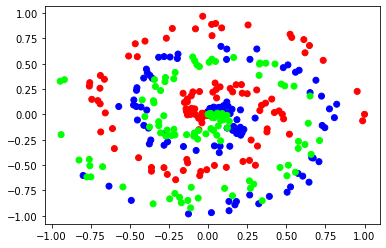

(300, 2)


In [95]:
import matplotlib.pyplot as plt
def spiral_data(points, classes):
    X = np.zeros((points*classes, 2))
    Y = np.zeros(points*classes, dtype='uint8')
    for class_number in range(classes):
        ix = range(points*class_number, points*(class_number+1))
        r = np.linspace(0.0, 1, points)  # radius
        t = np.linspace(class_number*4, (class_number+1)*4, points) + np.random.randn(points)*0.2
        X[ix] = np.c_[r*np.sin(t*2.5), r*np.cos(t*2.5)]
        Y[ix] = class_number
    return X, Y
X, Y = spiral_data(100,3)
X = np.array(X)
plt.scatter(X[:,0], X[:,1], c = Y, cmap = 'brg')
plt.show()

print(np.shape(X))


In [96]:
class layer():
    def __init__(self, inputs, neurons):
        self.weights = 0.01 * np.random.randn(inputs,neurons)
        self.biases = np.zeros((1,neurons))
    #FORWARD PASS:
    def forward(self,inputs):
        self.inputs = inputs
        self.output = np.dot(inputs,self.weights)+self.biases
    def backward(self,dvalues):
        self.dweights = np.dot(self.inputs.T,dvalues)
        self.dbiases = np.sum(dvalues,axis=0,keepdims=True)
        self.dinputs = np.dot(dvalues,self.weights.T)
        
class relu():
    def forward(self,inputs):
        self.inputs = inputs
        self.output = np.maximum(0,inputs)
    def backward(self,dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0
        
class softmax():
    def forward(self, inputs):
        self.inputs = inputs
        ex_batch = np.exp(inputs -  np.max(inputs , axis = 1 , keepdims = True))
        prob= ex_batch/np.sum(ex_batch , axis=1, keepdims = True)
        self.output = prob
        
    def backward(self,dvalues):
            self.dinputs = np.empty_like(dvalues)
            for i ,(single_output, single_dvalues) in enumerate(zip(self.output,dvalues)):
                single_output = single_output.reshape(-1,1)
                jacobian_matrix = np.diagflat(single_output)-np.dot(single_output, 
                                                                    single_output.T)
                self.dinputs[i] = np.dot(jacobian_matrix, single_dvalues)
            
class Loss:
    def calculate(self, output, y):
        sample_losses = self.forward(output , y)
        #calculate mean loss
        data_loss = np.mean(sample_losses)
        return data_loss
    
class CategoricalCrossEntropy_Loss(Loss):
    def forward(self , y_pred , y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred , 1e-8 , 1-1e-8)
               
        if len(y_true.shape) ==  1:
            confi = y_pred_clipped[range(samples),y_true]
        if len(y_true.shape) == 2:
            confi =  np.sum(y_pred_clipped * y_true,axis = 1)
        loss = -np.log(confi)
        return np.mean(loss)
    def backward(self,dvalues,y_true):
        samples = len(dvalues)
        labels = len(dvalues[0])
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
        #print(y_true)
        self.dinputs = -y_true/dvalues
        self.dinputs = self.dinputs/samples

class smax_crossentropy():
    def __init__(self):
        self.activation = softmax()
        self.loss = CategoricalCrossEntropy_Loss()
    def forward(self,inputs,y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output
        return self.loss.calculate(self.output,y_true)
    def backward(self,dvalues,y_true):
        samples = len(dvalues)
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true,axis = 1)
        self.dinputs = dvalues.copy()
        self.dinputs[range(samples),y_true]  -= 1
        self.dinputs = self.dinputs/samples

    

The **LEARNING RATE DECAY** starts with a large learning rate say "1.0" and gradually decrease it over time during training. There are a few well known methods of doing this:

One such method is to decrease the learning rate in response to the loss across epochs(iterations).

Another option is to use a **decay rate** which will steadily decrease the learning rate per
epoch(easier to implement).

### MOMENTUM
Imagine you're a rolling ball going downhill towards your destination, due to the force of gravity and other external factors you gain **momentum** , now you are approaching a cavity on the slope of the mountain but you won't get stuck in that cavity instead you leap over 
this cavity to rach towards your goal with the help of this **momentum**.

In relation to our optimization problem, there , maybe some cases where we the optimizer may get stuck in some local minimum ,  bouncing back and forth. With the help of momentum the optimizer is more likely to pass through local minimums with ease.
In other words, **MOMENTUM MSY STILL POINT TOWARDS THE GLOBAL MINIMUM**.


In [97]:
#We utilize momentum by setting a parameter between 0 and 1, representing the fraction of the 
#previous parameter update to be kept and then subtracting our actual gradient * learning rate.

In [98]:
class optimizer_sgd:
    def __init__(self,learning_rate=1.0,decay=0.0,momentum=0.0):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum
    
    def pre_update(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                                        (1/(1+self.decay*self.iterations))
   
    def update(self,layer):
        if self.momentum:
            #If there are no momentum arrays present we create them filled woth zeros:
            if not hasattr(layer,'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)
            weight_updater = self.momentum * layer.weight_momentums\
                                 -self.current_learning_rate*layer.dweights
            layer.weight_momentums = weight_updater
            bias_updater = self.momentum * layer.bias_momentums\
                           -self.current_learning_rate*layer.dbiases
            layer.bias_momentum = bias_updater
       
        else:
            weight_updater = -self.current_learning_rate * layer.dweights
            bias_updater = -self.current_learning_rate * layer.dbiases
        layer.weights += weight_updater
        layer.biases += bias_updater
    
    def post_update(self):
        self.iterations += 1

In [99]:
print(Y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2]


In [100]:
#model initialization:
layer1 = layer(2,64)
relu1 = relu()
layer2 = layer(64,3)
smax = softmax()
lossalt = CategoricalCrossEntropy_Loss()
catloss =  smax_crossentropy()
optimizer = optimizer_sgd(decay=1e-3,momentum=0.9)

for epoch in range(10001):
    #forward pass:
    layer1.forward(X)
    relu1.forward(layer1.output)
    layer2.forward(relu1.output)
    smax.forward(layer2.output)
    loss = lossalt.forward(smax.output,Y)
    # loss = catloss.forward(layer2.output,Y)
    #predictions = np.argmax(catloss.output,axis=1)
    predictions = np.argmax(smax.output,axis=1)
    if len(Y.shape) == 2:
        Y = np.argmax(Y, axis=1)
    accuracy = np.mean(predictions == Y)
    clr = optimizer.current_learning_rate  
    if not epoch % 1000:
        print(f'epoch:{epoch}'+ f'acc:{accuracy},' + f'loss{loss}'+
              f'lrate:{clr}')

    #backward pass:
    #catloss.backward(catloss.output,Y)
    lossalt.backward(smax.output,Y)
    smax.backward(lossalt.dinputs)
    layer2.backward(smax.dinputs)
    relu1.backward(layer2.dinputs)
    layer1.backward(relu1.dinputs)
    #optimizer:
    optimizer.pre_update()
    optimizer.update(layer1)
    optimizer.update(layer2)
    optimizer.post_update()
    
    
    

epoch:0acc:0.23666666666666666,loss1.0986591915009694lrate:1.0
epoch:1000acc:0.6333333333333333,loss0.7813617896190007lrate:0.5002501250625312
epoch:2000acc:0.5566666666666666,loss0.9069689789590779lrate:0.33344448149383127
epoch:3000acc:0.6633333333333333,loss0.7434282021951022lrate:0.25006251562890724
epoch:4000acc:0.7166666666666667,loss0.6398941878751084lrate:0.2000400080016003
epoch:5000acc:0.7033333333333334,loss0.7993063999502388lrate:0.16669444907484582
epoch:6000acc:0.77,loss0.5229458946118613lrate:0.1428775539362766
epoch:7000acc:0.8033333333333333,loss0.5067745986644919lrate:0.12501562695336915
epoch:8000acc:0.83,loss0.42870112276293887lrate:0.11112345816201799
epoch:9000acc:0.8433333333333334,loss0.38661185118813446lrate:0.1000100010001
epoch:10000acc:0.8533333333333334,loss0.3498928905173063lrate:0.09091735612328393


In [101]:
print("PRedictions",predictions)
print("TRue",Y)


PRedictions [2 1 1 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2
 2 0 2 2 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 2 0 2
 0 2 2 1 2 2 1 2 1 2 2 2 0 0 0 0 0 0 0 0 2 0 0 0 2 2 2 2 1 1 1 1 1 1 1 2 1
 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0
 2 2 2 2 2 0 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2
 2 2 2 2]
TRue [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

In [102]:
Xtest , Y_test = spiral_data(100,3)
layer1.forward(Xtest)
relu1.forward(layer1.output)
layer2.forward(relu1.output)

loss1 = catloss.forward(layer2.output,Y_test)
predictions1 = np.argmax(catloss.output,axis=1)
if len(Y_test.shape) == 2:
    Y_test = np.argmax(Y_test, axis=1)
accuracy1 = np.mean(predictions == Y_test)
print(accuracy1)
print(loss1)

0.8533333333333334
0.763871265023704
